In [22]:
from jax import random, jit, vmap
from functions.simulation import get_dataset, get_epsilon_star
from functions.training import train_loop
from functions.simulation import ABC_epsilon
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative
import jax.numpy as jnp
import time
import pickle 
import lzma
import numpy as np
import scipy.stats as stats
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return jnp.sort(random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return ((jnp.mean(y)-jnp.mean(y_true))**2)

key = random.PRNGKey(0)


MU0, SIGMA0 = 0., 20.
PRIOR_ARGS = [MU0, SIGMA0]

SIGMA = 1.
MODEL_ARGS = [SIGMA]

from jax.scipy.stats import norm
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)


N_DATA = 1
TRUE_MU = 40.
TRUE_DATA = data_simulator(key, TRUE_MU)

In [23]:
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

def delta(x):
    return 1

def sample_biased_post(key, z, L):
    key_sim, key_noise = random.split(key)
    delta = random.normal(key_noise, (1,))*jnp.abs(z)*.01
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(z))/(SIGMA0**2*len(z) + SIGMA**2) + delta
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return random.normal(key_sim, (L,))*jnp.sqrt(sigma2_post) + mu_post

sample_biased_post = jit(sample_biased_post, static_argnums = 2)
def SBC_biased_epsilon(key, N_SBC, L, epsilon, true_data, prior_simulator, data_simulator, discrepancy):
    datas, thetas_tilde, _, key = ABC_epsilon(key, N_SBC, prior_simulator, data_simulator, discrepancy, epsilon, true_data)
    key, sampling_key = random.split(key)
    sampling_keys = random.split(sampling_key, N_SBC)
    thetas = (vmap(sample_biased_post, in_axes = (0, 0, None)))(sampling_keys, datas, L)
    ranks = jnp.sum(thetas < thetas_tilde, axis = 1)
    return ranks, thetas_tilde, thetas, key

In [24]:
PRIOR = stats.norm(loc = MU0, scale = SIGMA0)

In [25]:
L = 127
B = 32
N_SBC = (L+1)*100
EPSILON = jnp.inf
EPSILONS = []
ACCEPT_RATES = [1., .999, .99, .975, .95, .925, .9, .85,.8,.75]
for ACCEPT_RATE in ACCEPT_RATES:
    print(f"\n\n---------\nACCEPT RATE = {ACCEPT_RATE:.2%}\n---------\n")
    EPSILON, key = get_epsilon_star(key, ACCEPT_RATE, 1000, prior_simulator, data_simulator, discrepancy, TRUE_DATA, .95, EPSILON)
    EPSILONS.append(EPSILON)
    

    



---------
ACCEPT RATE = 100.00%
---------

Distances: min =  0.0011274125 max =  11031.231 mean =  1943.6951 std =  1744.8038


---------
ACCEPT RATE = 99.90%
---------

Distances: min =  0.0013918674 max =  10429.243 mean =  1963.5834 std =  1707.4127
epsilon:  5221.6044921875 acceptance rate:  0.998


---------
ACCEPT RATE = 99.00%
---------

epsilon:  4405.20654296875 acceptance rate:  0.99200004
epsilon:  3813.970703125 acceptance rate:  0.994
epsilon:  3392.017822265625 acceptance rate:  0.989


---------
ACCEPT RATE = 97.50%
---------

epsilon:  3034.701904296875 acceptance rate:  0.98600006
epsilon:  2726.5634765625 acceptance rate:  0.99000007
epsilon:  2533.517333984375 acceptance rate:  0.989
epsilon:  2329.179931640625 acceptance rate:  0.97900003
epsilon:  2160.43896484375 acceptance rate:  0.98
epsilon:  1993.001708984375 acceptance rate:  0.97700006
epsilon:  1863.0223388671875 acceptance rate:  0.9760001
epsilon:  1752.616455078125 acceptance rate:  0.97300005


------

In [ ]:
find_grid_explorative()

In [31]:
EPSILONS2 = [np.inf, 1000, 100, 10, 5, 3, 2, 1]

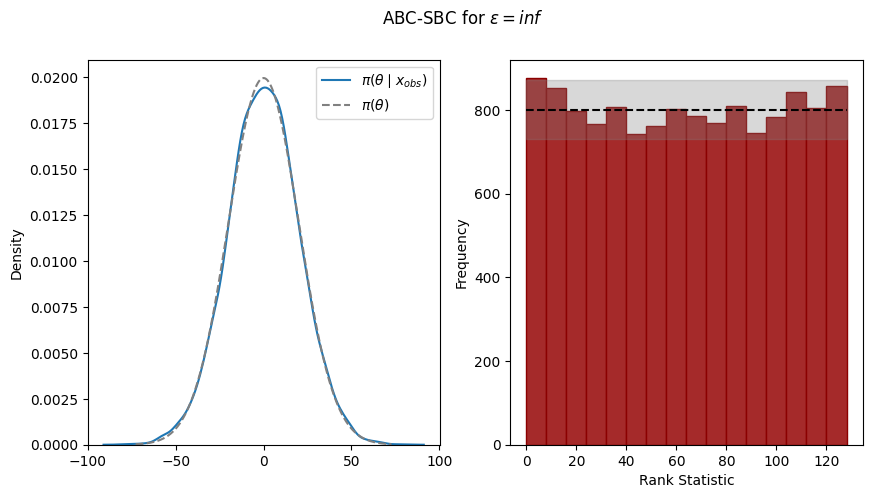

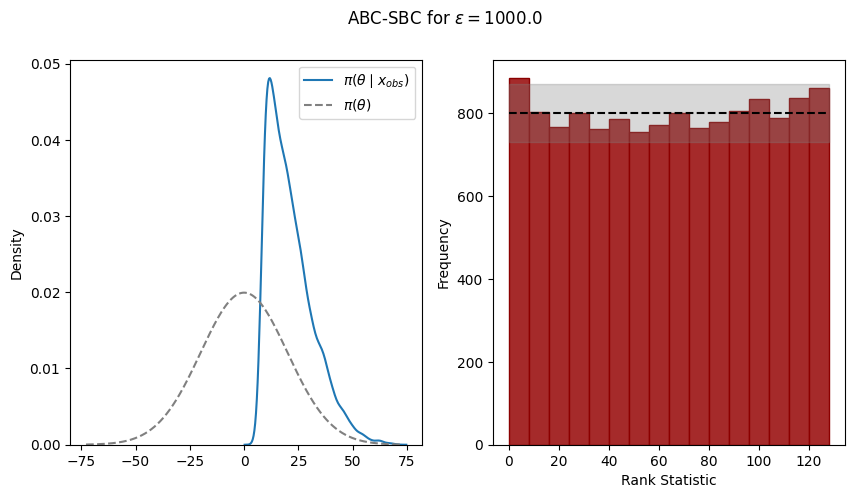

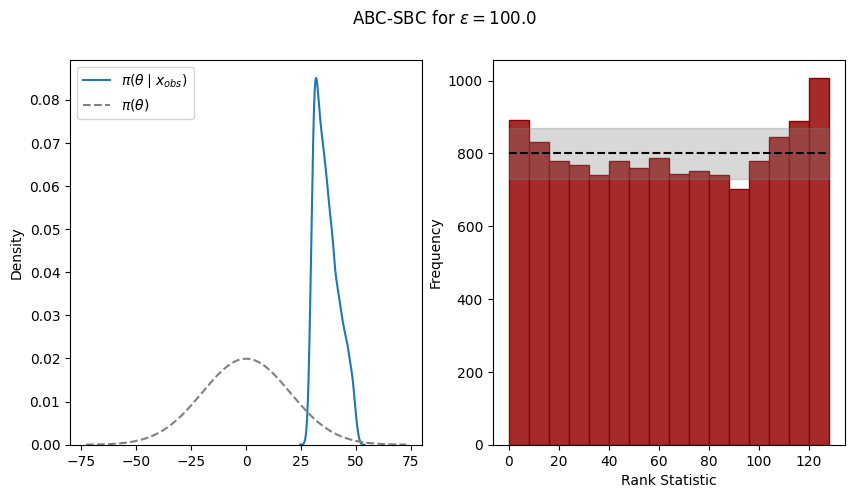

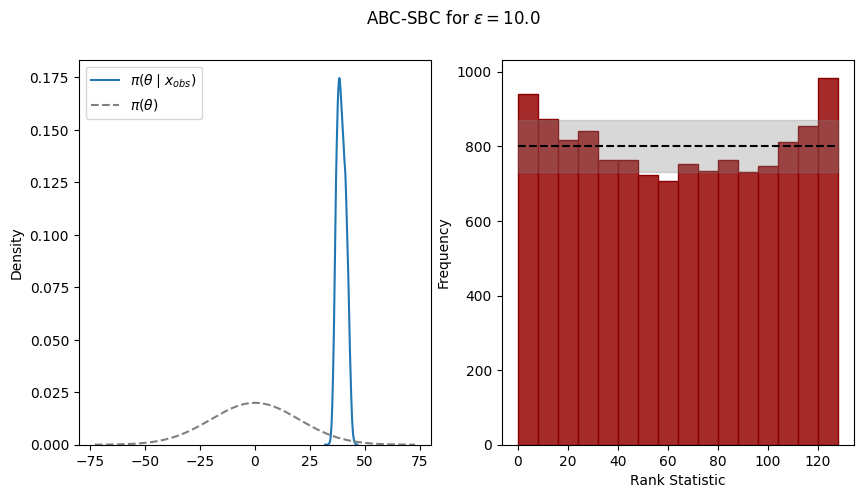

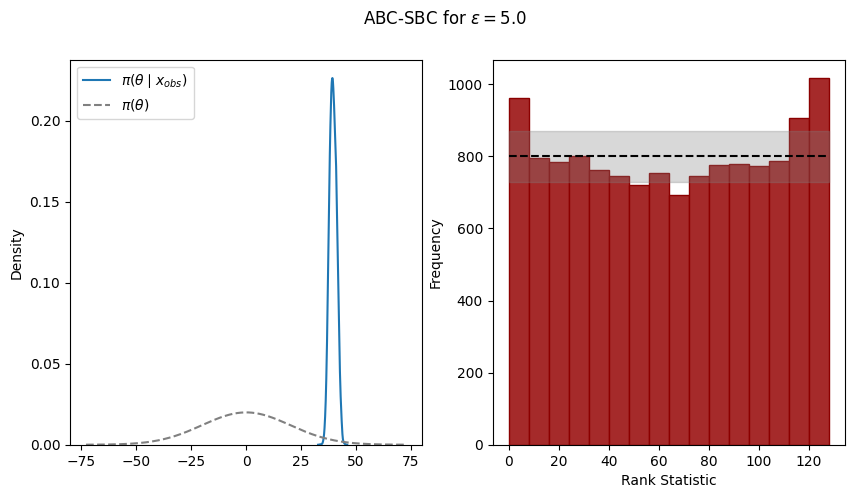

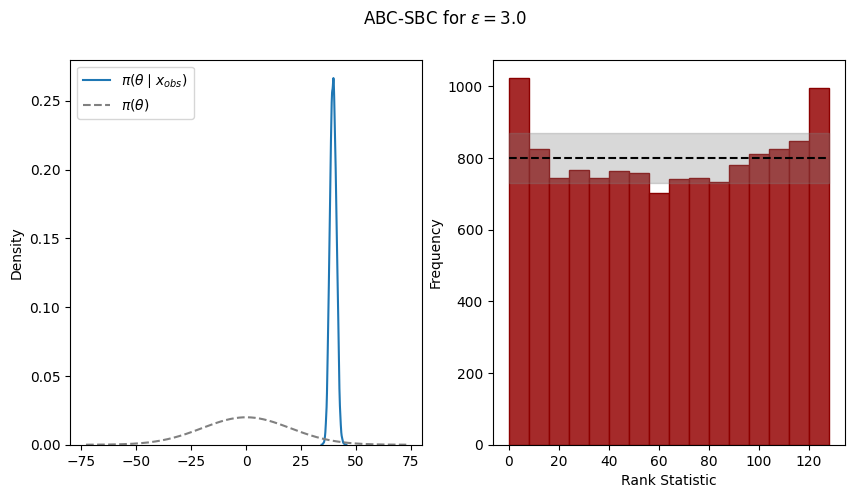

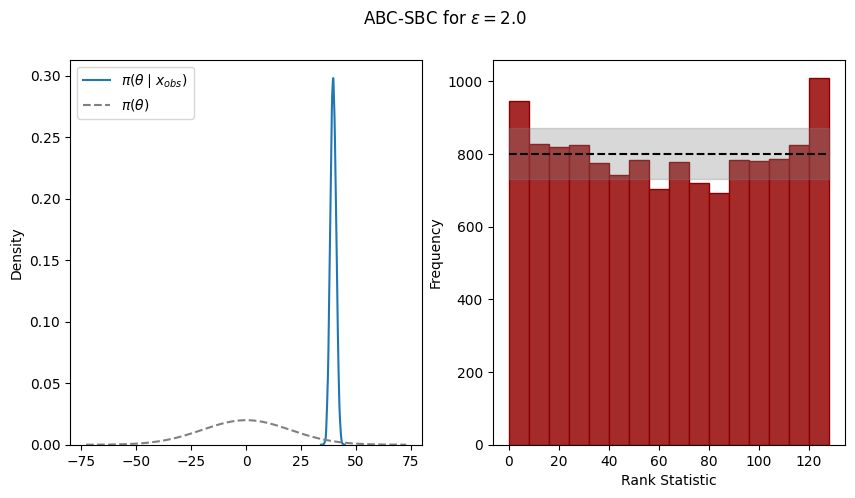

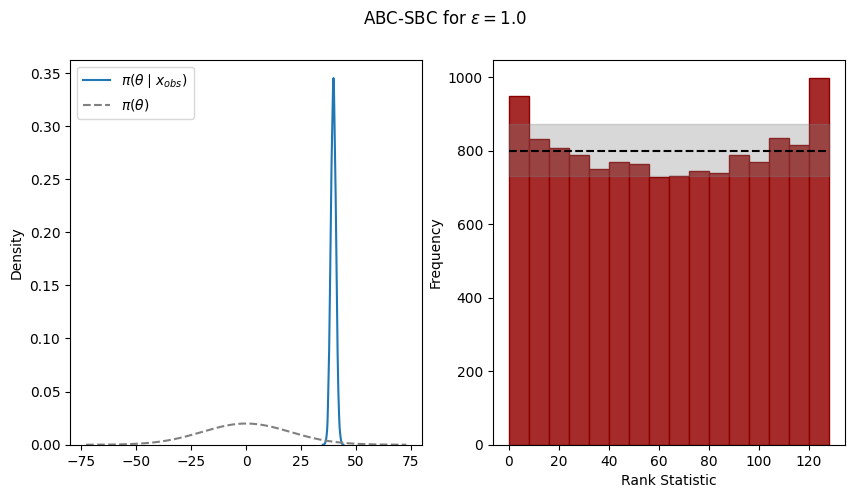

In [37]:
grid_prior, pdf_prior = find_grid_explorative(lambda x: PRIOR.pdf(x), 10000, 10000, -50, 50)
B = 16
for EPSILON in EPSILONS2:
    ranks, thetas_tilde, thetas, key = SBC_biased_epsilon(key, N_SBC, L, EPSILON, TRUE_DATA, prior_simulator, data_simulator, discrepancy)
    f, ax = plt.subplots(1,2, figsize = (10,5))
    # sns.kdeplot(thetas[:,0].flatten(), label = "Average", ax = ax[0])
    sns.kdeplot(thetas_tilde.flatten(), label = "$\pi(\\theta\mid x_{obs})$", ax= ax[0])

    ax[0].plot(grid_prior, pdf_prior, color = "grey", linestyle = "--", label = "$\pi(\\theta)$")
    ax[0].legend()
    f.suptitle(f"ABC-SBC for $\epsilon = {float(EPSILON)}$")
    plot_SBC(ranks, L, B, ax= ax[1])